In [413]:
import gurobipy as gp
from gurobipy import GRB
import tomllib as tml
import numpy as np
import display_helper as dh
from copy import deepcopy

Options looks like:
```
options = {
    "WLSACCESSID": "********-****-****-****-************",
    "WLSSECRET": "********-****-****-****-************",
    "LICENSEID": _____,
}
```

In [414]:
# get gurobi credentials
options = tml.load(open("license.toml", "rb"))

In [415]:
# establish env (must close)
env = gp.Env(params=options)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2527858
Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu


## Test with MPS File
I made a MPS file by solving LP.mod (written by Quan Luu) with GLPK for Windows.

In [416]:
m = gp.read("model.mps", env=env)
m.reset()
m.optimize()

Read MPS format model from file model.mps
Reading time = 0.01 seconds
LP: 757 rows, 729 columns, 2160 nonzeros
Discarded solution information
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu
Optimize a model with 757 rows, 729 columns and 2160 nonzeros
Model fingerprint: 0xcc557f7f
Variable types: 0 continuous, 729 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-03, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective -0.0927000
Presolve removed 27 rows and 0 columns
Presolve time: 0.01s
Presolved: 730 rows, 729 columns, 2160 nonzeros
Variable types: 0 continuous, 729 integer (729

I'm not sure this tells us much. Check `glpk_out.txt`, it has the full output of this solution. 
Notable slice:
```
730 rows, 729 columns, 2160 non-zeros
      0: obj =  -4.657500000e-01 inf =   1.000e+01 (2)
      5: obj =  -1.523000000e-01 inf =   0.000e+00 (0)
*   224: obj =   6.790500000e-01 inf =   2.065e-14 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   224: mip =     not found yet <=              +inf        (1; 0)
+   224: >>>>>   6.790500000e-01 <=   6.790500000e-01   0.0% (1; 0)
+   224: mip =   6.790500000e-01 <=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
Time used:   0.0 secs
Memory used: 1.9 Mb (1980226 bytes)
STATES:
[1 2 3]   [10 11 12]   [19 20 21]
[4 5 6] , [13 14 15] , [22 23 24].
[7 8 9]   [16 17 18]   [25 26 27]

BUCKETS:
Bucket 5: 1 2 3 4 5 6 7 8 9
Bucket 11: 11 12 19 21
Bucket 13: 10 13
Bucket 14: 14 15
Bucket 17: 16 17 18 25 26 27
Bucket 23: 20 22 23 24
```

## Problem Setup
I'm going to try and convert this outright to a Gurobi model.

In [417]:
# establish model (must close)
model = gp.Model(env=env)


Generating the probability matrix (Gaussian).

In [418]:
def normpdf(x: float, mean: float, std: float) -> float:
  var = float(std)**2
  denom = (2*np.pi*var)**.5
  num = np.exp(-(float(x)-float(mean))**2/(2*var))
  return num/denom

def gen_state_prob(num_traits: int, num_states: int):
  mean = (num_states-1) / 2
  std = mean / 1.25

  state_prob = np.zeros(tuple([num_states] * num_traits), dtype=np.float64)
  for inds in np.ndindex(state_prob.shape):
    prob = 1
    for ind in inds:
      prob *= normpdf(ind, mean, std)
    
    state_prob[inds] = prob

  state_prob = state_prob / np.sum(state_prob)

  return state_prob.flatten()

Generating the reward matrix.

In [419]:
def unnumerize(num_traits: int, num_states: int, action: int):
  ufaction = []
  while action > 0:
    ufaction.insert(0, action % num_states)
    action = action // num_states

  while len(ufaction) < num_traits:
    ufaction.insert(0, 0)

  return ufaction

def reward_fn(param: tuple[float, float], state, action):
  
  l1dist = 0
  for s, a in zip(state, action):
    l1dist += abs(s - a)

  return param[0] - param[1] * l1dist

def reward_matrix(num_traits: int, num_states: int, reward_param: tuple[float, float]):
  total_states = num_states**num_traits
  res = np.array([[0 for _ in range(total_states)] for _ in range(total_states)], dtype=np.float64)
  for x in range(total_states):
    for y in range(total_states):
      s1 = unnumerize(num_traits, num_states, x)
      s2 = unnumerize(num_traits, num_states, y)

      res[x, y] = reward_fn(reward_param, s1, s2)

  return res

Generating the neighbor list

In [420]:
def is_adj(num_traits: int, num_states: int, i: int, j: int):
  s1 = unnumerize(num_traits, num_states, i)
  s2 = unnumerize(num_traits, num_states, j)

  l1dist = 0
  for s, a in zip(s1, s2):
    l1dist += abs(s - a)

  return l1dist == 1

def neighbor_lst(num_traits: int, num_states: int):
  total_states = num_states**num_traits
  res = [[] for _ in range(total_states)]
  for x in range(total_states):
    for y in range(x, total_states):
      if is_adj(num_traits, num_states, x, y):
        res[x].append(y)
        res[y].append(x)

  return res

In [421]:
# parameters
t = 3                   # number of traits
n_per_t = 5             # number of states per trait
n = n_per_t**t          # total number of states
k = 6                   # number of signals 
reward_param = (1, 0.5) # reward parameter

V = np.asarray([i for i in range(n)])

state_prob = gen_state_prob(t, n_per_t)        # Gaussian
# state_prob = np.full(n, 1/n, dtype=np.float64) # uniform

reward = reward_matrix(t, n_per_t, reward_param)

neighbor = neighbor_lst(t, n_per_t)

Setting variables for maximizing payoff and minimizing cut edges

In [422]:
# Hess variables
# x[i, j] = 1 iff state i is in bucket j
# NOTE: 
# - "bucket j" means that action j is played in that bucket
# - x[i, j] == pr[signal j | state i] (probability of signal j given state i)
x = model.addVars(V, V, vtype=GRB.BINARY)

# cut egde variables
# y[i, j] = 1 iff edge {i, j} is cut
y = model.addVars(V, V, vtype=GRB.BINARY)

# flow variables
# f[i, j] = the flow from state i to state j
f = model.addVars(V, V)

Setting variables for maximizing information content

In [423]:
# converted x variables
# cx[i, j] = 0                   if x[i, j] = x[j, j] = 0 (nonexistant bucket)
#          = 1e-7                if x[i, j] = 0 and x[j, j] = 1 (states outside 
#                                 of bucket j)
#          = 1 - (k-1) * (1e-7)  if x[i, j] = x[j, j] = 1 (states in bucket j)
# NOTE: 
# - Avoids calculating log 0 when calculating KL divergence
# - cx[i, j] == (converted version of) pr[signal j | state i]
cx = model.addVars(V, V, vtype=GRB.CONTINUOUS)

# z variables
# z[i, j] = cx[i, j] * state_prob[i]
# NOTE: 
# - z[i, j] == pr[signal j | state i] * pr[state i] == pr[signal j, state i]
z = model.addVars(V, V, vtype=GRB.CONTINUOUS)

# w variables
# w[i] =              0                if x[j, j] = 0 (nonexistant bucket)
#      = 1 / sum( z[i, j] for i in V ) if x[j, j] = 1 (bucket j)
# NOTE: w[i] == 1 / sum( pr[signal j, state i] for all i) == 1 / pr[signal j]
w = model.addVars(V, vtype=GRB.CONTINUOUS)

# prob variables
# prob[i, j] = z[i, j] * w[i]
# NOTE: prob[i, j] == pr[signal j, state i] * (1/pr[signal j]) 
#                  == pr[state i | signal j]
prob = model.addVars(V, V, vtype=GRB.CONTINUOUS)

# probdiff variables
# probdiff[i, j] = prob[i, j] / state_prob[i]
# NOTE: probdiff[i, j] == pr[state i | signal j] / pr[state i]
probdiff = model.addVars(V, V, ub=27, vtype=GRB.CONTINUOUS)

# converted probdiff variables
# cprobdiff[i, j] = max(1, probdiff[i, j])
# NOTE: 
# - Avoids calculating log 0 when calculating KL divergence
# - If probdiff[i, j] == 0, then cprobdiff[i, j] == 1 so that taking the log would result in log 1 = 0
cprobdiff = model.addVars(V, V, ub=27, vtype=GRB.CONTINUOUS)

# log variables
# log[i, j] = log(cprobdiff[i, j])
# NOTE: log[i, j] == log(pr[state i | signal j] / pr[state i])
log = model.addVars(V, V, vtype=GRB.CONTINUOUS)

In [424]:
# state objective
# GPL: maximize EP: sum{i in V} PROB[i] * sum{j in V} x[i, j] * REWARD[i, j];
# gp.quicksum( prob[i] * x[i][j] * reward[i][j] for i in V for j in V )

# payoff with min cut edge
# NOTE: maximizing payoff takes priority over minimizing cut edges so the payoff is multiplied by a big number before subtracting the number of cut edges
objective = gp.quicksum( gp.quicksum( (state_prob[i] * x[i,j] * reward[i][j]) for j in V) for i in V ) / n * (n**2 + 1) * 10000 - gp.quicksum( y[i, j] for i in V for j in V )

# # payoff
# objective = gp.quicksum( gp.quicksum( (state_prob[i] * x[i,j] * reward[i][j]) for j in V) for i in V ) / n

# # info measure
# objective = gp.quicksum( gp.quicksum( prob[i,j] * log[i,j] for j in V) for i in V)

model.setObjective(objective, GRB.MAXIMIZE)

In [425]:
# add constraints

# /* there are exactly k buckets */
# kBucketConstr: sum{j in V} x[j, j] = k;
k_bucket = gp.quicksum( (x[j,j]) for j in V ) == k
model.addConstr(k_bucket)

# /* a state can only belong to one bucket */
# uniqueBucketConstr{i in V}: sum{j in V} x[i, j] = 1;
unique_bucket = ( gp.quicksum( (x[i,j]) for j in V ) == 1 for i in V )
model.addConstrs(unique_bucket)

# /* a state cannot belong to a non-existant bucket */
# nonexBucketConstr{i in V, j in V}: x[i, j] <= x[j, j];
nonex_bucket = ( (x[i,j] <= x[j,j]) for i in V for j in V )
model.addConstrs(nonex_bucket)

model.update()


In [426]:
# add constraints for flow
M = n - k + 1

# /* cut edge constraints */
# edge {i, j} is cut if i and j are not adjacent.
cut_edge_not_adj = ( y[i, j] == 1 for i in V for j in np.setdiff1d(V, np.array(neighbor[i])) )
model.addConstrs(cut_edge_not_adj)

# edge {i, j} is cut if i and j are in different buckets.
cut_edge_diff_bucket = ( y[i, j] >= x[i, l] - x[j, l] for i in V for j in V for l in V)
model.addConstrs(cut_edge_diff_bucket)

# do not send flow across cut edges
cut_edge_flow = ( f[i, j] + f[j, i] <= M * (1 - y[i, j]) for i in V for j in V )
model.addConstrs(cut_edge_flow)

# /* flow constraint */
# if not a root, consume some flow.
# if a root, only send out (so much) flow.
flow = ( gp.quicksum( f[j, i]- f[i, j] for j in neighbor[i] )
      >= 1 - M * x[i, i] for i in V )
model.addConstrs(flow)

model.update()

In [427]:
# # add constraints for info measure

# # converted x constraint
# small_val_constr_1 = ( cx[i, j] <= x[j, j] * (x[i, j] + 1e-7)  for i in V for j in V )
# model.addConstrs(small_val_constr_1)

# small_val_constr_2 = ( cx[i, j] >= x[j, j] * (1e-7) for i in V for j in V )
# model.addConstrs(small_val_constr_2)

# sum_cx_constr = ( gp.quicksum( cx[i, j] for j in V ) == 1 for i in V )
# model.addConstrs(sum_cx_constr)

# # z constraint
# z_constr = ( z[i, j] == cx[i, j] * state_prob[i] for i in V for j in V )
# model.addConstrs(z_constr)

# # w constraint
# # NOTE: Although w[j] = x[j, j] / sum(z[i, j] for i in V), gurobi does not
# # allow dividing by a variable
# # w_constr = ( w[j] * gp.quicksum(z[i, j] for i in V) == x[j, j] for j in V )
# w_constr = ( w[j] * gp.quicksum(cx[i, j] for i in V) == x[j, j] for j in V )
# model.addConstrs(w_constr)

# # NOTE: To ensure that w[j] == 0 when x[j, j] == 0
# w_zero = ( w[j] * x[j, j] == w[j] for j in V )
# model.addConstrs(w_zero)

# # prob constraint
# # prob_constr = ( prob[i, j] == z[i, j] * w[j] for i in V for j in V )
# prob_constr = ( prob[i, j] == cx[i, j] * w[j] for i in V for j in V )
# model.addConstrs(prob_constr)

# # probdiff constraint
# probdiff_constr = ( probdiff[i, j] == prob[i, j] / state_prob[i] for i in V for j in V )
# model.addConstrs(probdiff_constr)

# # converted probdiff constraint
# cprobdiff_constr = ( cprobdiff[i, j] == gp.max_(probdiff[i, j], constant=1) for i in V for j in V )
# model.addConstrs(cprobdiff_constr)

# # log constraint
for i in V:
  for j in V:
    model.addGenConstrLog(cprobdiff[i, j], log[i, j])

# model.update()

Additional constraints for testing purposes

In [428]:
# # test constraints
# for i in range(24):
#   model.addConstrs(x[i, j] == x[i+1, j] for j in V)

# model.update()

Solving the model

In [429]:
# multiple solutions
model.Params.PoolSolutions = 1
model.Params.PoolSearchMode = 2

model.update()

# can we solve?
model.optimize()

Set parameter PoolSolutions to value 1
Set parameter PoolSearchMode to value 2
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2527858 - for non-commercial use only - registered to mb___@ur.rochester.edu
Optimize a model with 1999651 rows, 140750 columns and 5937975 nonzeros
Model fingerprint: 0xa0979328
Variable types: 109500 continuous, 31250 integer (31250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 6e+04]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 1e+02]
Presolve removed 1908300 rows and 30050 columns
Presolve time: 2.32s
Presolved: 91351 rows, 110700 columns, 274875 nonzeros
Variable types: 94475 continuous, 16225 integer (16225 binary)
Root relaxation presolved: 90751 rows, 110700 columns, 2

In [430]:
# # Testing
# for i in V:
#   print([f"{x[i,j].getAttr("X"):.1f}" for j in V])
# print()
# for i in V:
#   print([cx[i,j].getAttr("X") for j in V])
# print()
# test = 0
# for i in V:
#   print([z[i,j].getAttr("X") for j in V])
#   for j in V:
#     test += z[i,j].getAttr("X")
# print(test)
# print([w[i].getAttr("X") for i in V])
# print()
# for i in V:
#   print([f"{prob[i,j].getAttr("X"):.2f}" for j in V])
# print()
# for i in V:
#   print([f"{cprobdiff[i,j].getAttr("X"):.2f}" for j in V])
# print()
# for i in V:
#   print([np.log(cprobdiff[i,j].getAttr("X")) for j in V])
# print()

# test = 0
# for i in V:
#   for j in V:
#     test += prob[i, j].getAttr("X") * log[i, j].getAttr("X")

# print(test)


### Solution Extraction
This was a little easier than I thought, thanks to Quan's code.

Bucket 37: 1 2 6 7 11 12 16 17 21 22 26 27 31 32 36 37 41 42 46 47 
Bucket 39: 4 5 9 10 13 14 15 19 20 24 25 29 30 34 35 38 39 40 44 45 49 50 
Bucket 58: 3 8 28 33 51 52 53 54 55 56 57 58 59 60 78 83 103 108 
Bucket 68: 18 23 43 48 63 66 67 68 69 70 71 72 73 74 75 93 98 118 123 
Bucket 87: 61 62 76 77 81 82 86 87 91 92 96 97 101 102 106 107 111 112 116 117 121 122 
Bucket 89: 64 65 79 80 84 85 88 89 90 94 95 99 100 104 105 109 110 113 114 115 119 120 124 125 


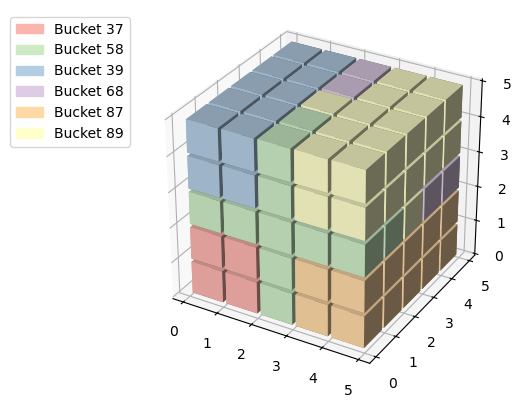

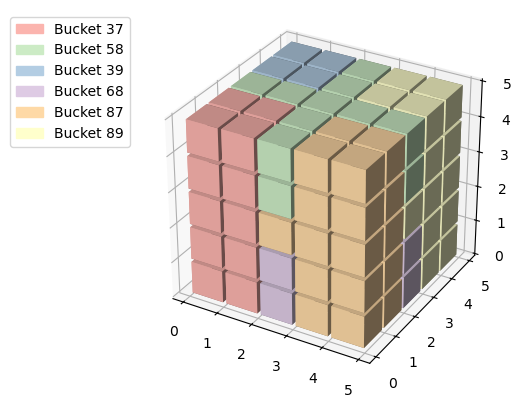

In [431]:
centers = [j for j in V if round(x[j,j].getAttr("x")) == 1]
bucket_lookup = dict()

for ind, j in enumerate(centers):
    print(f"Bucket {j+1}: ", end="")
    members = [i for i in V if round(x[i,j].getAttr("x")) == 1]
    for i in members:
        print(f"{i+1} ", end="")
        bucket_lookup[i] = ind
    print()

og_cube, legend = dh.cube_from_lookup(bucket_lookup, n_per_t, centers)
dh.show(og_cube, legend)

cube = deepcopy(og_cube)

cube = dh.rotate_aboutX(cube)
dh.show(cube, legend)


```
STATES:
[1  2  3  4  5]    [26 27 28 29 30]   [51 52 53 54 55]
[6  7  8  9  10]   [31 32 33 34 35]   [56 57 58 59 60]
[11 12 13 14 15] , [36 37 38 39 40] , [61 62 63 64 65] ,
[16 17 18 19 20]   [41 42 43 44 45]   [66 67 68 69 70]
[21 22 23 24 25]   [46 47 48 49 50]   [71 72 73 74 75]

[76 77 78 79 80]   [101 102 103 104 105]
[81 82 83 84 85]   [106 107 108 109 110]
[86 87 88 89 90] , [111 112 113 114 115]
[91 92 93 94 95]   [116 117 118 119 120]
[96 97 98 99 100]  [121 122 123 124 125]

```

<!-- BUCKETS:
Bucket 5: 1 2 3 4 5 6 7 8 9
Bucket 11: 11 12 19 21
Bucket 13: 10 13
Bucket 14: 14 15
Bucket 17: 16 17 18 25 26 27
Bucket 23: 20 22 23 24

GLPK Output again for comparison. -->

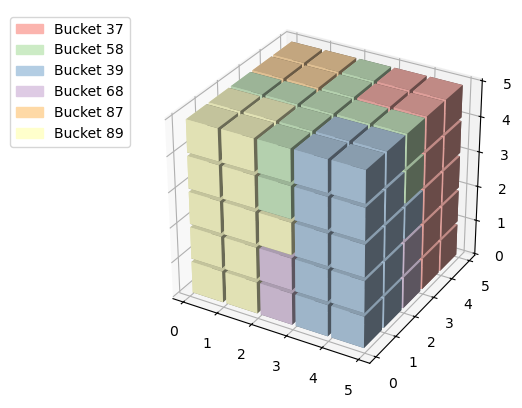

In [436]:
cube = dh.rotate_aboutZ(cube)
dh.show(cube, legend)

Convert strategy to calculate information content measure.

In [433]:
def convert(num_traits, num_states, num_signals, strat):
  total_states = num_states**num_traits
  small_val = 1e-7
  large_val = 1 - (small_val * (num_signals-1))

  signal_strat = np.full((num_signals, total_states), small_val, dtype=np.float64)

  for i, bucket in enumerate(strat):
    for state in bucket:
      signal_strat[i, state] = large_val

  return signal_strat

def info_measure(num_traits, num_states, num_signals, signal_prob, weighted=True) -> float:
    """Calculates the information content of the signals

    Args:
      signal_prob (np.ndarray): the probabilities of the signals
      weighted (boolean): weighted/unweighted options

    Returns:
      inf (float): total information content measure
      inf_sigs (list): information content by signal
      inf_states (list): information content by state
    """
    total_states = num_states**num_traits
    signal_prob = signal_prob.reshape(num_signals, total_states)

    prob = np.zeros_like(signal_prob)
    for i in range(num_signals):
      for j in range(total_states):
        prob[i, j] = signal_prob[i, j] * state_prob[j]
    prob_sig = [np.sum(prob[i]) for i in range(num_signals)]
    prob = (prob.T / np.sum(prob, axis=1)).T

    inf = 0
    inf_sigs = []
    inf_states = []
    for i in range(num_signals):
      inf_sig = 0
      inf_states.append([])
      for j in range(total_states):
        inf_state = prob[i, j] * np.log(prob[i, j]/state_prob[j])
        inf_sig += inf_state
        
        if weighted:
          inf_state = prob_sig[i] * inf_state

        inf_states[i].append(inf_state)

      if weighted:
        inf_sig = prob_sig[i] * inf_sig

      inf_sigs.append(inf_sig)
      inf += inf_sig

    new_size = [num_signals]
    new_size.extend([num_states] * num_traits)
    inf_states = np.resize(np.array(inf_states), tuple(new_size))

    return inf, inf_sigs, inf_states

def stats(inf, inf_sigstates):
  inf_states = np.sum(inf_sigstates, axis=0)

  print(f"Info measure = {inf}")
  print(f"Info measure by states:")

  for t1 in inf_states:
    for t2 in t1:
      for t3 in t2:
        print(f"{t3:.3f}", end=" ")
      print()
    print()

Calculating the average information content and payoff of all n results

In [434]:
# n solutions
n_solutions = model.getAttr("SolCount")
print(f"Number of solutions: {n_solutions}")

new_size = [k]
new_size.extend([n_per_t] * t)

total_info = 0
total_info_sigstates = np.zeros(tuple(new_size))
total_w_info = 0
total_w_info_sigstates = np.zeros(tuple(new_size))

for sol in range(0, n_solutions):
    model.params.SolutionNumber = sol
    centers = [j for j in V if round(x[j,j].getAttr("Xn")) == 1]
    strat = []

    # # printing out the solution
    # print(f"Solution {sol+1}")

    for j in centers:
        members = [i for i in V if round(x[i,j].getAttr("Xn")) == 1]
        strat.append(members)

        # # printing out the buckets
        # print(f"Bucket {j+1}: ", end="")
        # for i in members:
        #     print(f"{i+1} ", end="")
        # print()

    converted_strat = convert(t, n_per_t, k, strat)
        
    inf, inf_sigs, inf_sigstates = info_measure(t, n_per_t, k, converted_strat, False)

    # # printing the information content
    # print(f"Info measure={inf}")

    w_inf, w_inf_sigs, w_inf_sigstates = info_measure(t, n_per_t, k, converted_strat)

    total_info += inf
    total_info_sigstates += inf_sigstates

    total_w_info += w_inf
    total_w_info_sigstates += w_inf_sigstates

    
avg_info = total_info / n_solutions
avg_info_sigstates = total_info_sigstates / n_solutions
avg_w_info = total_w_info / n_solutions
avg_w_info_sigstates = total_w_info_sigstates / n_solutions

# printing the objective
print(f"Objective = {model.ObjVal}\n")

# printing the payoff of the first solution
op = 0
for i in V:
    for j in V:
        op += state_prob[i] * x[i,j].getAttr("X") * reward[i][j]
print(f"Payoff = {op / n}")

# printing the average information content
print("UNWEIGHTED")
stats(avg_info, avg_info_sigstates)
print()
print("WEIGHTED")
stats(avg_w_info, avg_w_info_sigstates)

Number of solutions: 1
Objective = 253878.16854595434

Payoff = 0.001722060466824231
UNWEIGHTED
Info measure = 10.803962359257097
Info measure by states:
0.034 0.060 0.047 0.045 0.025 
0.060 0.109 0.084 0.080 0.045 
0.073 0.132 0.119 0.098 0.054 
0.060 0.109 0.069 0.080 0.045 
0.034 0.060 0.039 0.045 0.025 

0.060 0.109 0.084 0.080 0.045 
0.109 0.195 0.151 0.144 0.080 
0.132 0.237 0.213 0.176 0.098 
0.109 0.195 0.125 0.144 0.080 
0.060 0.109 0.069 0.080 0.045 

0.047 0.084 0.102 0.084 0.047 
0.084 0.151 0.184 0.151 0.084 
0.119 0.213 0.185 0.165 0.092 
0.069 0.125 0.152 0.125 0.069 
0.039 0.069 0.084 0.069 0.039 

0.045 0.080 0.084 0.062 0.035 
0.080 0.144 0.151 0.111 0.062 
0.098 0.176 0.165 0.136 0.075 
0.080 0.144 0.125 0.111 0.062 
0.045 0.080 0.069 0.062 0.035 

0.025 0.045 0.047 0.035 0.019 
0.045 0.080 0.084 0.062 0.035 
0.054 0.098 0.092 0.075 0.042 
0.045 0.080 0.069 0.062 0.035 
0.025 0.045 0.039 0.035 0.019 


WEIGHTED
Info measure = 1.783085185313765
Info measure by states:

In [435]:
# closing these objects for best practice

model.close()
m.close()
env.close()